In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [82]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV  # Logistic Regression model
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier    # Ensemble models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
import plotly.express as px
import plotly.graph_objects as go

In [3]:
from data_engineering import de

In [4]:
df = pd.read_csv("data/movie_data.csv")

/Users/daiglechris/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (0,1,2,3,4,5,6,7,8,9,10,13,14,15,16,19) have mixed types.Specify dtype option on import or set low_memory=False.



In [5]:
# Initial analysis of dataframe
null_0 = pd.DataFrame(df.isnull().sum()).reset_index()
null_0.rename(columns={'index': 'factor', 0: 'num_null_0'}, inplace=True)
null_0.sort_values(by='num_null_0', axis=0, ascending=False, inplace=True)
null_0['miss_prop_0'] = round(null_0['num_null_0'] / df.shape[0], 4) * 100
df_info = {'obs_0':df.shape[0],
           'fac_0':df.shape[1],
           'null_0': null_0}
# Transformations to more accurately reflect data integrity issues
numeric_cols = ['budget', 'popularity', 'revenue',
                'runtime', 'vote_average', 'vote_count']
for col in numeric_cols:
    df[col] = df[col].apply(lambda x: pd.to_numeric(x, downcast='float', errors='coerce'))
df['id'] = df['id'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df['release_date'] = df['release_date'].apply(lambda x: pd.to_datetime(x, errors='coerce'))
# Remove observations related to response variables
df = df.dropna(how='any', subset=['vote_count', 'vote_average', 'revenue'])
# Dataframe of the number of missing values after null removals
trans_0_null = pd.DataFrame(df.isnull().sum()).reset_index()
trans_0_null.rename(columns={'index': 'factor', 0: 'num_null_1'}, inplace=True)
trans_0_null['miss_prop_1'] = round(trans_0_null['num_null_1'] / df.shape[0], 4) * 100
null_1 = null_0.join(trans_0_null.set_index('factor'), on='factor')
# Update dataframe information dictionary
df_info['obs_1'] = df.shape[0]
df_info['fac_1'] = df.shape[1]
df_info['null_1'] = null_1

In [6]:
print("Initial observations: {:,}".format(df_info['obs_0']))
print("Number of observations after removing missing 'vote_count', 'vote_average', 'revenue': {:,}".format(df_info['obs_1']))

Initial observations: 133,744
Number of observations after removing missing 'vote_count', 'vote_average', 'revenue': 28,477


In [7]:
df_info['null_1'].sort_values('miss_prop_1', ascending=False)

factor  num_null_0  miss_prop_0  num_null_1  miss_prop_1
2               homepage      114113        85.32       24461        85.90
15               tagline      120766        90.30       15499        54.43
6               overview       33226        24.84         458         1.61
12               runtime      105434        78.83         170         0.60
10          release_date      105375        78.79         111         0.39
13      spoken_languages      105264        78.71           0         0.00
3                     id       32768        24.50           0         0.00
4      original_language       32768        24.50           0         0.00
5         original_title       32768        24.50           0         0.00
1                 genres       32768        24.50           0         0.00
7             popularity      105264        78.71           0         0.00
11               revenue      105264        78.71           0         0.00
8   production_companies      105264        78.71           0         0.00
19              keywords      105267        78.71           0         0.00
14                status      105267        78.71           0         0.00
16                 title      105267        78.71           0         0.00
17          vote_average      105267        78.71           0         0.00
18            vote_count      105267        78.71           0         0.00
9   production_countries      105267        78.71           0         0.00
0                 budget           0         0.00           0         0.00

In [8]:
for col in df.columns:
    print(col)
    print(df[col].dtypes)
    print("{:.2%} null".format(df[col].isna().sum() / df.shape[0]))
    display(df[col].head())
    print("+" * len(col))

budget
float64
0.00% null


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: budget, dtype: float64

++++++
genres
object
0.00% null


0                       [{"id": 35, "name": "Comedy"}]
1                    [{"id": 12, "name": "Adventure"}]
2    [{"id": 10749, "name": "Romance"}, {"id": 18, ...
3                       [{"id": 35, "name": "Comedy"}]
4                                                   []
Name: genres, dtype: object

++++++
homepage
object
85.90% null


0                        NaN
1                        NaN
2                        NaN
3                        NaN
4    http://www.nwdfilms.com
Name: homepage, dtype: object

++++++++
id
float64
0.00% null


0     3924.0
1     6124.0
2     8773.0
3    21624.0
4    25449.0
Name: id, dtype: float64

++
original_language
object
0.00% null


0    en
1    de
2    fr
3    pa
4    en
Name: original_language, dtype: object

+++++++++++++++++
original_title
object
0.00% null


0                               Blondie
1                   Der Mann ohne Namen
2                   L'amour à vingt ans
3                      Jatts in Golmaal
4    New World Disorder 9: Never Enough
Name: original_title, dtype: object

++++++++++++++
overview
object
1.61% null


0    Blondie and Dagwood are about to celebrate the...
1    Der Mann ohne Namen is a German adventure movi...
2    Love at Twenty unites five directors from five...
3    Jatts in Golmal is an Comedy based movie. In w...
4    Gee Atherton ripping the Worlds course the day...
Name: overview, dtype: object

++++++++
popularity
float64
0.00% null


0    3.067
1    0.845
2    3.701
3    0.600
4    1.212
Name: popularity, dtype: float64

++++++++++
production_companies
object
0.00% null


0    [{"id": 5, "logo_path": "/71BqEFAF4V3qjjMPCpLu...
1                                                   []
2    [{"id": 38936, "logo_path": null, "name": "Uly...
3                                                   []
4                                                   []
Name: production_companies, dtype: object

++++++++++++++++++++
production_countries
object
0.00% null


0    [{"iso_3166_1": "US", "name": "United States o...
1            [{"iso_3166_1": "DE", "name": "Germany"}]
2    [{"iso_3166_1": "DE", "name": "Germany"}, {"is...
3                                                   []
4                                                   []
Name: production_countries, dtype: object

++++++++++++++++++++
release_date
datetime64[ns]
0.39% null


0   1938-11-30
1   1921-01-01
2   1962-06-22
3   2003-02-21
4   2008-12-08
Name: release_date, dtype: datetime64[ns]

++++++++++++
revenue
float64
0.00% null


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: revenue, dtype: float64

+++++++
runtime
float64
0.60% null


0     70.0
1    420.0
2    110.0
3      NaN
4     69.0
Name: runtime, dtype: float64

+++++++
spoken_languages
object
0.00% null


0             [{"iso_639_1": "en", "name": "English"}]
1                                                   []
2    [{"iso_639_1": "de", "name": "Deutsch"}, {"iso...
3                                                   []
4             [{"iso_639_1": "en", "name": "English"}]
Name: spoken_languages, dtype: object

++++++++++++++++
status
object
0.00% null


0    Released
1    Released
2    Released
3    Released
4    Released
Name: status, dtype: object

++++++
tagline
object
54.43% null


0                                     NaN
1                                     NaN
2    The Intimate Secrets of Young Lovers
3                                     NaN
4                                     NaN
Name: tagline, dtype: object

+++++++
title
object
0.00% null


0                               Blondie
1         Peter Voss, Thief of Millions
2                        Love at Twenty
3                      Jatts in Golmaal
4    New World Disorder 9: Never Enough
Name: title, dtype: object

+++++
vote_average
float64
0.00% null


0    6.6
1    0.0
2    6.9
3    0.0
4    4.5
Name: vote_average, dtype: float64

++++++++++++
vote_count
float64
0.00% null


0     4.0
1     0.0
2    27.0
3     0.0
4     2.0
Name: vote_count, dtype: float64

++++++++++
keywords
object
0.00% null


0                  [{"id": 190801, "name": "blondie"}]
1                                                   []
2                                                   []
3                                                   []
4    [{"id": 6075, "name": "sport"}, {"id": 10192, ...
Name: keywords, dtype: object

++++++++


## Data Engineering Strategy
For each column in the dataframe, here's some info and my plan to handle them:
1. **budget**: float64, 0% null
> *ALREADY CONVERTED TO FLOAT AND COERCED NAN*
2. **genres**: object, 0% null, array holding dictionary, ex: `x = [{"id": 35, "name": "Comedy"}]`
> *DRAW VALUE FROM "name" FROM EACH ELEMENT FROM ARRAY, ASSIGN NAN IF EMPTY*
3. **homepage**: object, 85.9% null
> *DROP: TOO MUCH MISSING*
4. **id**: float64, 0% null
> *DROP: NO INFORMATION*
5. **original_language**: object, 0% null
> *ENFORCE STRING*
6. **original_title**: object, 0% null
> *ENFORCE STRING*
7. **overview**: object, 1.61% null
> *ENFORCE STRING*
8. **popularity**: float64, 0% null
9. **production_companies**: object, 0% null, array holding dictionary
> *DRAW VALUE FROM "name" FROM EACH ELEMENT FROM ARRAY, ASSIGN NAN IF EMPTY*
10. **production_countries**: object, 0% null, array holding dictionaries
> *DRAW VALUE FROM "iso_3166_1" FROM EACH ELEMENT FROM ARRAY, ASSIGN NAN IF EMPTY*
11. **release_date**: datetime64, 0.39% null
> *ALREADY CONVERTED TO DATETIME AND FILLED NAN, DROP MISSING OBSERVATIONS AS SO FEW*
12. **revenue**: float64, 0% null
> *RESPONSE VARIABLE*
13. **runtime**: float64, 0.6% null
> *ALREADY CONVERTED TO FLOAT AND COERCED NAN, DROP MISSING OBSERVATIONS AS SO FEW*
14. **spoken_languages**: object, 0% null, array of dictionaries
> *Drop and see if valuable after using only original_language*<br>
> If brought back in...<br>
> *DRAW VALUE FROM "iso_639_1" FROM EACH ELEMENT FROM ARRAY, ASSIGN NAN IF EMPTY, CAPITALIZE*
15. **status**: object, 0% null
> *CHECK IF BINARY INDICATOR*
16. **tagline**: object, 54.43% null
> *FIND RELATIONSHIP BETWEEN ORIGINAL_LANGUAGE, PRODUCTION_COUNTRIES, AND STATUS*
17. **title**: object, 0% null
18. **vote_average**: float64, 0% null
> *PREVIOUSLY CONVERTED TO FLOAT AND DROPPED MISSING*
19. **vote_count**: float64, 0% null
> *PREVIOUSLY CONVERTED TO FLOAT AND DROPPED MISSING*
20. **keywords**: object, 0% null, array holding dictionaries
> *DRAW VALUE FROM "name" FROM EACH ELEMENT FROM ARRAY, ASSIGN NAN IF EMPTY*

In [9]:
df['genres'] = de.string_array_clean(df_col=df['genres'], element='name')
df.drop(['homepage', 'id'], axis=1, inplace=True)
df = df.dropna(how='any', subset=['release_date', 'runtime'])
df['original_language'] = df['original_language'].astype(str)
df['original_title'] = df['original_title'].astype(str)
df['overview'] = df['overview'].astype(str)
df['production_companies'] = de.string_array_clean(df_col=df['production_companies'], element='name')
df['production_countries'] = de.string_array_clean(df_col=df['production_countries'], element='iso_3166_1')
df['spoken_languages'] = de.string_array_clean(df_col=df['spoken_languages'], element='iso_639_1')
df['tagline'] = df['tagline'].astype(str)
df['title'] = df['title'].astype(str)
df['keywords'] = de.string_array_clean(df_col=df['keywords'], element='name')
df.reset_index(inplace = True, drop = True)

In [10]:
df.head()

budget            genres original_language  \
0     0.0          [Comedy]                en   
1     0.0       [Adventure]                de   
2     0.0  [Romance, Drama]                fr   
3     0.0              None                en   
4     0.0          [Family]                en   

                       original_title  \
0                             Blondie   
1                 Der Mann ohne Namen   
2                 L'amour à vingt ans   
3  New World Disorder 9: Never Enough   
4      Sesame Street: Elmo Loves You!   

                                            overview  popularity  \
0  Blondie and Dagwood are about to celebrate the...       3.067   
1  Der Mann ohne Namen is a German adventure movi...       0.845   
2  Love at Twenty unites five directors from five...       3.701   
3  Gee Atherton ripping the Worlds course the day...       1.212   
4  Elmo is making a very, very super special surp...       0.843   

                                production_companies  production_countries  \
0                                [Columbia Pictures]                  [US]   
1                                               None                  [DE]   
2  [Ulysse Productions, Unitec Films, Cinesecolo,...  [DE, FR, IT, JP, PL]   
3                                               None                  None   
4                                               None                  None   

  release_date  revenue  runtime      spoken_languages    status  \
0   1938-11-30      0.0     70.0                  [en]  Released   
1   1921-01-01      0.0    420.0                  None  Released   
2   1962-06-22      0.0    110.0  [de, fr, it, ja, pl]  Released   
3   2008-12-08      0.0     69.0                  [en]  Released   
4   2010-01-05      0.0     46.0                  None  Released   

                                tagline                               title  \
0                                   nan                             Blondie   
1                                   nan       Peter Voss, Thief of Millions   
2  The Intimate Secrets of Young Lovers                      Love at Twenty   
3                                   nan  New World Disorder 9: Never Enough   
4                                   nan      Sesame Street: Elmo Loves You!   

   vote_average  vote_count                keywords  
0           6.6         4.0               [blondie]  
1           0.0         0.0                    None  
2           6.9        27.0                    None  
3           4.5         2.0  [sport, mountain bike]  
4           0.0         0.0                    None

In [11]:
# Initial analysis of dataframe
trans_null_2 = pd.DataFrame(df.isnull().sum()).reset_index()
trans_null_2.rename(columns={'index': 'factor', 0: 'num_null_2'}, inplace=True)
null_2 = null_1.join(trans_null_2.set_index('factor'), on='factor')
df_info['obs_2'] = df.shape[0]
df_info['fac_2'] = df.shape[1]
df_info['null_2'] = null_2

In [12]:
df_info['null_2']['miss_prop_2'] = round(df_info['null_2']['num_null_2'] / df.shape[0], 4) * 100
df_info['null_2'].sort_values('miss_prop_2', ascending=False)

factor  num_null_0  miss_prop_0  num_null_1  miss_prop_1  \
19              keywords      105267        78.71           0         0.00   
8   production_companies      105264        78.71           0         0.00   
9   production_countries      105267        78.71           0         0.00   
13      spoken_languages      105264        78.71           0         0.00   
1                 genres       32768        24.50           0         0.00   
15               tagline      120766        90.30       15499        54.43   
4      original_language       32768        24.50           0         0.00   
5         original_title       32768        24.50           0         0.00   
6               overview       33226        24.84         458         1.61   
7             popularity      105264        78.71           0         0.00   
11               revenue      105264        78.71           0         0.00   
12               runtime      105434        78.83         170         0.60   
14                status      105267        78.71           0         0.00   
16                 title      105267        78.71           0         0.00   
17          vote_average      105267        78.71           0         0.00   
18            vote_count      105267        78.71           0         0.00   
10          release_date      105375        78.79         111         0.39   
0                 budget           0         0.00           0         0.00   
2               homepage      114113        85.32       24461        85.90   
3                     id       32768        24.50           0         0.00   

    num_null_2  miss_prop_2  
19      7051.0        24.99  
8       6643.0        23.54  
9       2658.0         9.42  
13      1568.0         5.56  
1       1048.0         3.71  
15         0.0         0.00  
4          0.0         0.00  
5          0.0         0.00  
6          0.0         0.00  
7          0.0         0.00  
11         0.0         0.00  
12         0.0         0.00  
14         0.0         0.00  
16         0.0         0.00  
17         0.0         0.00  
18         0.0         0.00  
10         0.0         0.00  
0          0.0         0.00  
2          NaN          NaN  
3          NaN          NaN

## Parse these crazy lists

            genres  num_obs   prop
0            Drama    11318  40.11
1           Comedy     9108  32.28
2         Thriller     4930  17.47
3           Action     4431  15.70
4          Romance     3923  13.90
5           Horror     3600  12.76
6            Crime     3117  11.05
7        Adventure     2504   8.87
8  Science Fiction     2141   7.59
9           Family     2111   7.48
Average: 3,057
Median: 2,111.0
Number of distinct: 19


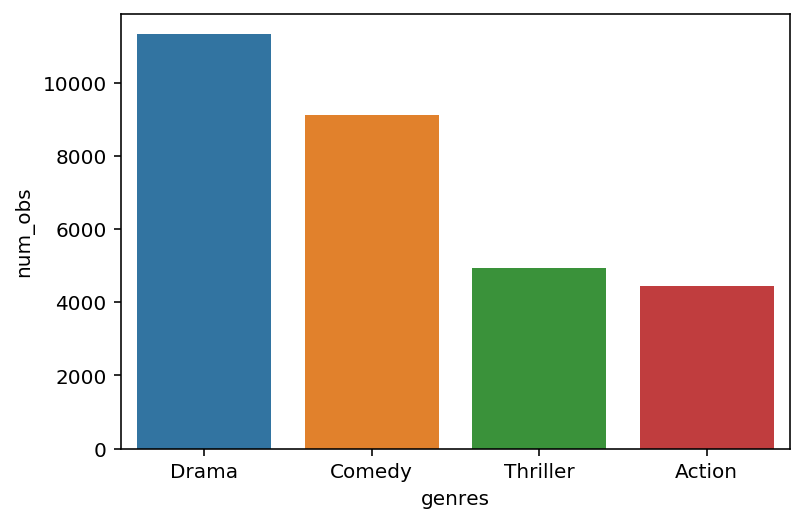

In [13]:
top_ten_genres = de.col_arr_parse(df,'genres')

                 keywords  num_obs  prop
0          woman director     1270  4.50
1        independent film     1203  4.26
2                  murder     1038  3.68
3  based on novel or book      918  3.25
4                 musical      611  2.17
5                   sport      577  2.04
6                violence      529  1.87
7                 revenge      462  1.64
8           new york city      445  1.58
9                    noir      415  1.47
Average: 8
Median: 2.0
Number of distinct: 16,334


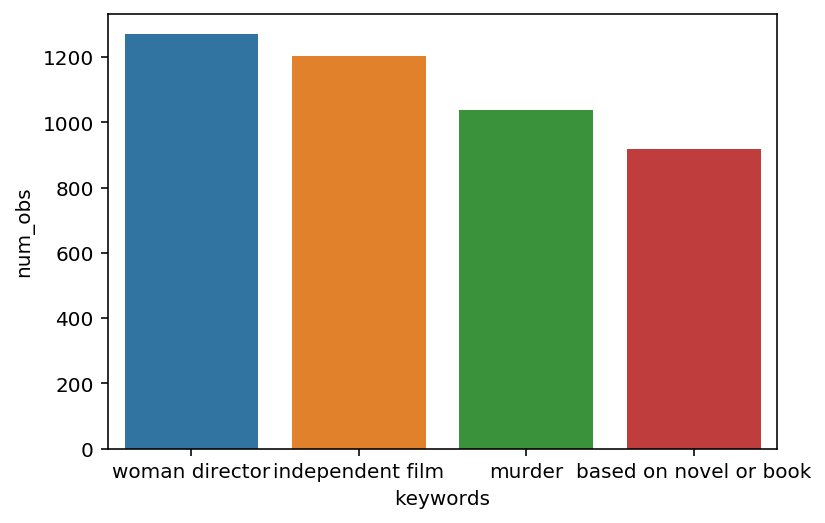

In [14]:
top_ten_kw = de.col_arr_parse(df,'keywords')

    production_companies  num_obs  prop
0  Warner Bros. Pictures      857  3.04
1              Paramount      729  2.58
2     Universal Pictures      700  2.48
3      Columbia Pictures      661  2.34
4       20th Century Fox      646  2.29
5    Metro-Goldwyn-Mayer      622  2.20
6                 Canal+      282  1.00
7         United Artists      246  0.87
8   Walt Disney Pictures      237  0.84
9        New Line Cinema      230  0.82
Average: 3
Median: 1.0
Number of distinct: 15,726


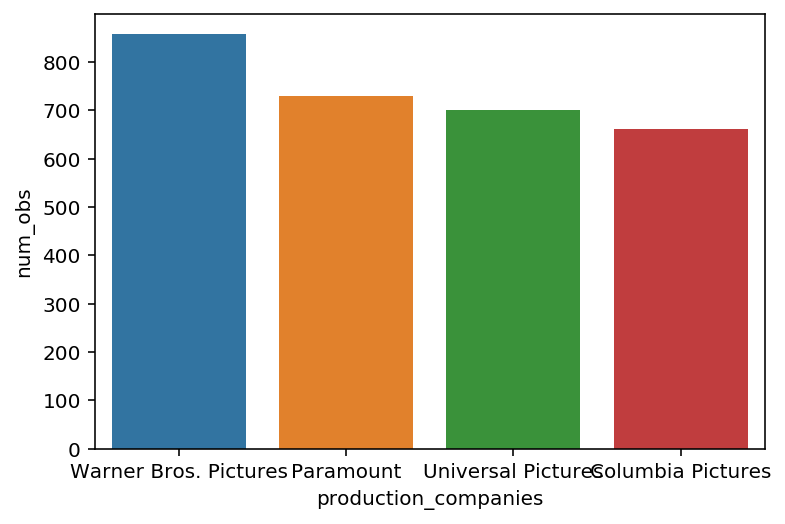

In [15]:
top_ten_prod_comp = de.col_arr_parse(df,'production_companies')

  production_countries  num_obs   prop
0                   US    14182  50.26
1                   GB     2780   9.85
2                   DE     2292   8.12
3                   FR     2217   7.86
4                   IT     1261   4.47
5                   JP     1176   4.17
6                   CA     1060   3.76
7                   ES      626   2.22
8                   IN      484   1.72
9                   HK      455   1.61
Average: 227
Median: 7.0
Number of distinct: 141


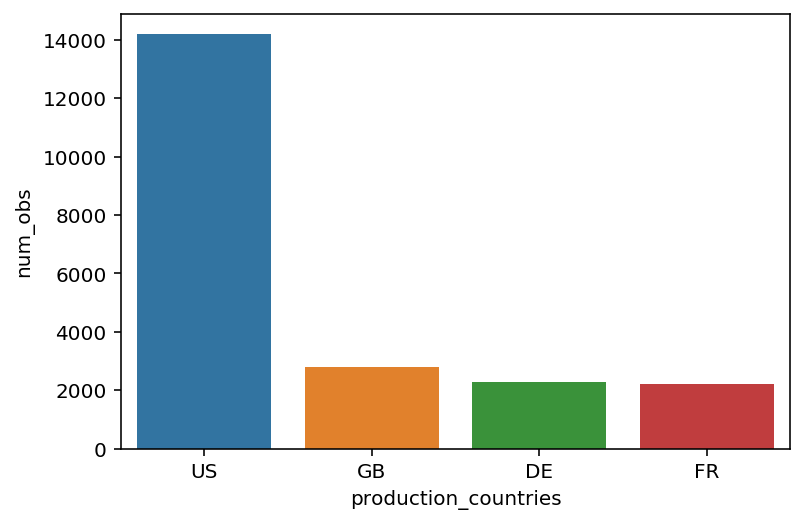

In [16]:
top_ten_prod_cont = de.col_arr_parse(df,'production_countries')

  spoken_languages  num_obs   prop
0               en    18773  66.53
1               fr     2604   9.23
2               de     2440   8.65
3               es     1697   6.01
4               it     1407   4.99
5               ja     1182   4.19
6               ru      681   2.41
7               zh      479   1.70
8               hi      425   1.51
9               da      382   1.35
Average: 282
Median: 9.0
Number of distinct: 123


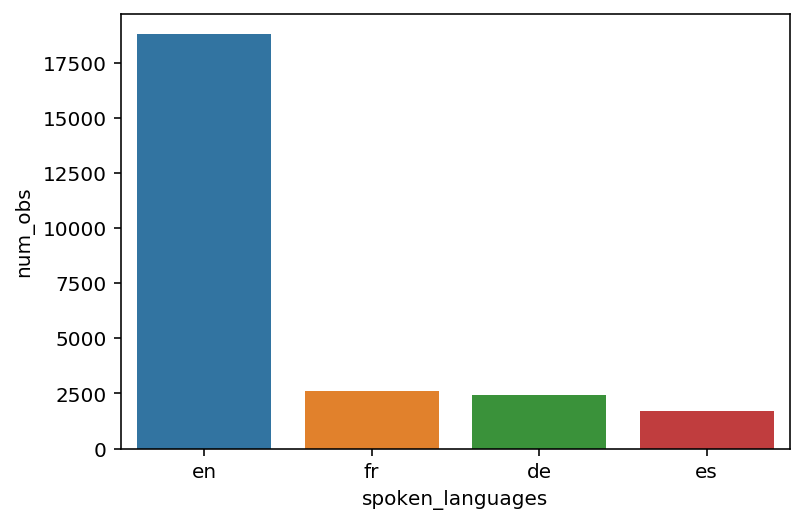

In [17]:
top_ten_sp_lang = de.col_arr_parse(df,'spoken_languages')

# NEXT STEP: Indicate if observation is in the top-ten

In [18]:
df['genres_top'] = df['genres'].apply(lambda x: de.top_rep(x_i=x, top_list=top_ten_genres))
df['keywords_top'] = df['keywords'].apply(lambda x: de.top_rep(x_i=x, top_list=top_ten_kw))
df['production_companies_top'] = df['production_companies'].apply(lambda x: de.top_rep(x_i=x, top_list=top_ten_prod_comp, indicate=True))
df['production_countries_top'] = df['production_countries'].apply(lambda x: de.top_rep(x_i=x, top_list=top_ten_prod_cont, indicate=True))
df['spoken_language_top'] = df['spoken_languages'].apply(lambda x: de.top_rep(x_i=x, top_list=top_ten_sp_lang))

In [19]:
df['genres_top'].value_counts()

0.1    9496
0.2    9073
0.3    4580
0.0    2628
0.4    1194
0.5     170
0.6      29
Name: genres_top, dtype: int64

In [20]:
df['keywords_top'].value_counts()

0.0    14697
0.1     5608
0.2      742
0.3      106
0.4       12
0.5        2
Name: keywords_top, dtype: int64

In [21]:
df['production_companies_top'].value_counts()

0.0    16481
1.0     5094
Name: production_companies_top, dtype: int64

In [22]:
df['production_countries_top'].value_counts()

1.0    22570
0.0     2990
Name: production_countries_top, dtype: int64

In [23]:
df['spoken_language_top'].value_counts()

0.1    20586
0.2     3141
0.0     1956
0.3      743
0.4      170
0.5       40
0.6        7
0.7        5
0.8        2
Name: spoken_language_top, dtype: int64

In [24]:
df_1 = df.drop(['genres','keywords', 'production_companies', 'production_countries', 'spoken_languages'], axis=1).copy()
df_1.reset_index(inplace = True, drop = True)

In [25]:
# # Find average revenue per year, find if observation's revenue is above average revenue, create indicator variable
df_1.reset_index(inplace = True, drop = True)
df_1['year'] = pd.to_datetime(df_1['release_date'], format='%Y-%m-%d').dt.year
ave_rev = {}
for year in set(df_1['year']):
    ave_rev[year] = round(df_1[df_1['year'] == year]['revenue'].mean())
df_1['above_ave_rev_yr'] = 0
for i in range(df_1.shape[0]):
    yr = df_1.loc[i,'year']
    ave_yr_rev = ave_rev[yr]
    if df_1.loc[i,'revenue'] >= ave_yr_rev:
        df_1.loc[i,'above_ave_rev_yr'] = 1
    else:
        continue
df_1['above_ave_rev_yr'] = df_1['above_ave_rev_yr'].astype(int)
df_1.drop('year', axis=1, inplace=True)
df_1.reset_index(inplace = True, drop = True)

In [26]:
# Analsis of dataframe after addressing columns with lists of elements:
trans_null_3 = pd.DataFrame(df_1.isnull().sum()).reset_index()
trans_null_3.rename(columns={'index': 'factor', 0: 'num_null_3'}, inplace=True)
null_3 = trans_null_3.join(null_2.set_index('factor'), on='factor')
df_info['obs_3'] = df_1.shape[0]
df_info['fac_3'] = df_1.shape[1]
df_info['null_3'] = null_3
df_info['null_3']['miss_prop_3'] = round(df_info['null_3']['num_null_3'] / df.shape[0], 4) * 100
df_1.reset_index(inplace = True, drop = True)
df_info['null_3'].sort_values('miss_prop_3', ascending=False)

factor  num_null_3  num_null_0  miss_prop_0  num_null_1  \
14              keywords_top        7051         NaN          NaN         NaN   
15  production_companies_top        6643         NaN          NaN         NaN   
16  production_countries_top        2658         NaN          NaN         NaN   
17       spoken_language_top        1568         NaN          NaN         NaN   
13                genres_top        1048         NaN          NaN         NaN   
0                     budget           0         0.0         0.00         0.0   
10                     title           0    105267.0        78.71         0.0   
12                vote_count           0    105267.0        78.71         0.0   
11              vote_average           0    105267.0        78.71         0.0   
9                    tagline           0    120766.0        90.30     15499.0   
1          original_language           0     32768.0        24.50         0.0   
8                     status           0    105267.0        78.71         0.0   
7                    runtime           0    105434.0        78.83       170.0   
6                    revenue           0    105264.0        78.71         0.0   
5               release_date           0    105375.0        78.79       111.0   
4                 popularity           0    105264.0        78.71         0.0   
3                   overview           0     33226.0        24.84       458.0   
2             original_title           0     32768.0        24.50         0.0   
18          above_ave_rev_yr           0         NaN          NaN         NaN   

    miss_prop_1  num_null_2  miss_prop_2  miss_prop_3  
14          NaN         NaN          NaN        24.99  
15          NaN         NaN          NaN        23.54  
16          NaN         NaN          NaN         9.42  
17          NaN         NaN          NaN         5.56  
13          NaN         NaN          NaN         3.71  
0          0.00         0.0          0.0         0.00  
10         0.00         0.0          0.0         0.00  
12         0.00         0.0          0.0         0.00  
11         0.00         0.0          0.0         0.00  
9         54.43         0.0          0.0         0.00  
1          0.00         0.0          0.0         0.00  
8          0.00         0.0          0.0         0.00  
7          0.60         0.0          0.0         0.00  
6          0.00         0.0          0.0         0.00  
5          0.39         0.0          0.0         0.00  
4          0.00         0.0          0.0         0.00  
3          1.61         0.0          0.0         0.00  
2          0.00         0.0          0.0         0.00  
18          NaN         NaN          NaN         0.00

# Handle Categoricals:
1. original_language: dummies
2. original_title: count length, drop
3. overview: count length, drop
4. status: dummies
5. tagline: count length, drop
6. title: count length, drop

In [27]:
# 1. original_language: dummies
df_dum = pd.get_dummies(df_1['original_language'], dummy_na=True, drop_first=True)
df_1 = pd.concat([df_1.drop(columns='original_language'), df_dum], axis=1)
df_1.shape

(28218, 92)

In [28]:
# 2. original_title: count length, drop
df_1['orig_title_len'] = df_1['original_title'].apply(lambda x: x.count(' ') + 1 if len(x) !=0 else 0)
df_1 = df_1.drop(columns='original_title')
df_1.shape

(28218, 92)

In [29]:
# 3. overview: count length, drop
df_1['overview_len'] = df_1['overview'].apply(lambda x: x.count(' ') + 1 if len(x) !=0 else 0)
df_1 = df_1.drop(columns='overview')
df_1.shape

(28218, 92)

In [30]:
# 4. status: dummies
df_dum = pd.get_dummies(df_1['status'], dummy_na=True, drop_first=True)
df_1 = pd.concat([df_1.drop(columns='status'), df_dum], axis=1)
df_1.shape

(28218, 92)

In [31]:
# 5. tagline: count length, drop
df_1['tagline_len'] = df_1['tagline'].apply(lambda x: x.count(' ') + 1 if len(x) !=0 else 0)
df_1 = df_1.drop(columns='tagline')
df_1.shape

(28218, 92)

In [32]:
# 6. title: count length, drop
df_1['title_len'] = df_1['title'].apply(lambda x: x.count(' ') + 1 if len(x) !=0 else 0)
df_1 = df_1.drop(columns='title')
df_1.shape

(28218, 92)

In [33]:
df_1.reset_index(inplace = True, drop = True)

# Impute with with KNN

In [34]:
imputer = KNNImputer(n_neighbors=int(round(np.sqrt(df_1.shape[0]))))

In [35]:
%%time
df_1.reset_index(inplace = True, drop = True)
impute_df = df_1.drop(columns='release_date')
impute_df_filled = imputer.fit_transform(X=impute_df)

CPU times: user 1min 10s, sys: 6.33 s, total: 1min 16s
Wall time: 1min 11s


In [36]:
imputed_cols = list(df_1.drop(columns='release_date').columns)
df_impute = pd.DataFrame(data=impute_df_filled, columns=imputed_cols)
df_impute.head()

budget  popularity  revenue  runtime  vote_average  vote_count  genres_top  \
0     0.0       3.067      0.0     70.0           6.6         4.0    0.100000   
1     0.0       0.845      0.0    420.0           0.0         0.0    0.100000   
2     0.0       3.701      0.0    110.0           6.9        27.0    0.200000   
3     0.0       1.212      0.0     69.0           4.5         2.0    0.095833   
4     0.0       0.843      0.0     46.0           0.0         0.0    0.100000   

   keywords_top  production_companies_top  production_countries_top  ...   vi  \
0      0.000000                  1.000000                  1.000000  ...  0.0   
1      0.024405                  0.047619                  1.000000  ...  0.0   
2      0.038095                  0.000000                  1.000000  ...  0.0   
3      0.100000                  0.107143                  0.815476  ...  0.0   
4      0.027381                  0.053571                  0.892857  ...  0.0   

    xx   zh   zu  NaN  orig_title_len  overview_len  NaN  tagline_len  \
0  0.0  0.0  0.0  0.0             1.0          36.0  0.0          1.0   
1  0.0  0.0  0.0  0.0             4.0          14.0  0.0          1.0   
2  0.0  0.0  0.0  0.0             4.0          41.0  0.0          6.0   
3  0.0  0.0  0.0  0.0             6.0          68.0  0.0          1.0   
4  0.0  0.0  0.0  0.0             5.0          94.0  0.0          1.0   

   title_len  
0        1.0  
1        5.0  
2        3.0  
3        6.0  
4        5.0  

[5 rows x 91 columns]

In [37]:
df_1_impute_fill = pd.concat([df_impute, df_1['release_date']], axis=1)
df_1_impute_fill.head()

budget  popularity  revenue  runtime  vote_average  vote_count  genres_top  \
0     0.0       3.067      0.0     70.0           6.6         4.0    0.100000   
1     0.0       0.845      0.0    420.0           0.0         0.0    0.100000   
2     0.0       3.701      0.0    110.0           6.9        27.0    0.200000   
3     0.0       1.212      0.0     69.0           4.5         2.0    0.095833   
4     0.0       0.843      0.0     46.0           0.0         0.0    0.100000   

   keywords_top  production_companies_top  production_countries_top  ...   xx  \
0      0.000000                  1.000000                  1.000000  ...  0.0   
1      0.024405                  0.047619                  1.000000  ...  0.0   
2      0.038095                  0.000000                  1.000000  ...  0.0   
3      0.100000                  0.107143                  0.815476  ...  0.0   
4      0.027381                  0.053571                  0.892857  ...  0.0   

    zh   zu  NaN  orig_title_len  overview_len  NaN  tagline_len  title_len  \
0  0.0  0.0  0.0             1.0          36.0  0.0          1.0        1.0   
1  0.0  0.0  0.0             4.0          14.0  0.0          1.0        5.0   
2  0.0  0.0  0.0             4.0          41.0  0.0          6.0        3.0   
3  0.0  0.0  0.0             6.0          68.0  0.0          1.0        6.0   
4  0.0  0.0  0.0             5.0          94.0  0.0          1.0        5.0   

   release_date  
0    1938-11-30  
1    1921-01-01  
2    1962-06-22  
3    2008-12-08  
4    2010-01-05  

[5 rows x 92 columns]

# Scale Data

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1)) # default=(0, 1)
numerical = ['orig_title_len', 'overview_len', 'tagline_len', 'title_len',
             'popularity', 'runtime', 'vote_average', 'vote_count']

df_impute_log_minmax = pd.DataFrame(data = df_1_impute_fill).copy()
df_impute_log_minmax[numerical] = scaler.fit_transform(df_1_impute_fill[numerical])

# Preserve final df transformation:
df_impute_transformed = df_impute_log_minmax

In [49]:
df_final = df_impute_transformed.copy()

In [50]:
df_final.shape

(28218, 92)

# Posing the Questions:

What's the relationship between a movie's rating and revenue

In [51]:
fig = px.histogram(df_final,
                   x='vote_average',
                   color='above_ave_rev_yr',
                  opacity=0.75)
fig.update_layout(title_text="Distribution of Ratings",
                  showlegend=True)
fig.update_yaxes(title_text="Number of Votes")
fig.update_xaxes(title_text="Average Vote")
fig.update_layout(legend_title_text='Above Average Revenue for Year')
fig.show()

What's the relationship between a movie's age and ratings

In [52]:
fig = px.scatter(df_final,
                 x="release_date",
                 y="vote_count")
fig.update_layout(title='Relationship of Release Date and Vote Count')
fig.update_yaxes(title_text="Number of Votes")
fig.update_xaxes(title_text="Year")
fig.show()

Can I predict revenue:

In [53]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

In [54]:
X = df_final.drop(['revenue', 'above_ave_rev_yr', 'release_date'], axis=1)
y = df_final['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
lm_model = LinearRegression(normalize=True)
r_model = Ridge(normalize=True)

lm_model.fit(X_train, y_train)
r_model.fit(X_train, y_train)
print('Linear Regression Train R2: {}'.format(lm_model.score(X_train, y_train)))
print('Ridge Train R2: {}'.format(r_model.score(X_train, y_train)))

lm_preds = lm_model.predict(X_test)
r_preds = r_model.predict(X_test)
print('Linear Regression Test R2: {}'.format(round(lm_model.score(X_test, y_test),4)))
print('Ridge Test R2: {}'.format(round(r_model.score(X_test, y_test),4)))

Linear Regression Train R2: 0.76354213745444
Ridge Train R2: 0.6544291213406286
Linear Regression Test R2: -3.154566238553024e+21
Ridge Test R2: 0.5573


Can I predict if revenue is higher than the average for the year:

In [64]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV  # Logistic Regression model
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier    # Ensemble models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score

In [79]:
models = {'log_model': LogisticRegression(random_state=0),
          'log_cv_model': LogisticRegressionCV(),
          'ab_model':AdaBoostClassifier(random_state=0),
          'rf_model': RandomForestClassifier(random_state=0),
          'grad_model': GradientBoostingClassifier(random_state=0),
          'knn_model': KNeighborsClassifier()}
X = df_final.drop(['revenue', 'above_ave_rev_yr', 'release_date'], axis=1)
y = df_final['above_ave_rev_yr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [80]:
results = {}
for model in models.keys():
    name = models[model].__class__.__name__
    models[model].fit(X_train, y_train)
    
    pred_train = models[model].predict(X_train)
    pred_test = models[model].predict(X_test)
    
    acc_train = accuracy_score(y_train, pred_train)
    acc_test = accuracy_score(y_test, pred_test)
    
    f_train = fbeta_score(y_train, pred_train, beta=1)
    f_test = fbeta_score(y_test, pred_test, beta=1)
    
    results[name] = {'pred_train': pred_train,
                     'pred_test': pred_test,
                     'acc_train': acc_train,
                     'acc_test': acc_test,
                     'f_train': f_train,
                     'f_test': f_test}
    

In [81]:
for model in results.keys():
    print(model)
    print("="*len(model))
    print('\tTrain Accuracy: {:.4}'.format(results[model]['acc_train']))
    print('\tTest Accuracy: {:.4}'.format(results[model]['acc_test']))
    print('\tTrain F1: {:.4}'.format(results[model]['f_train']))
    print('\tTest F1: {:.4}'.format(results[model]['f_test']))

LogisticRegression
	Train Accuracy: 0.8547
	Test Accuracy: 0.849
	Train F1: 0.5841
	Test F1: 0.5684
LogisticRegressionCV
	Train Accuracy: 0.8547
	Test Accuracy: 0.849
	Train F1: 0.5841
	Test F1: 0.5684
AdaBoostClassifier
	Train Accuracy: 0.9414
	Test Accuracy: 0.9382
	Train F1: 0.7419
	Test F1: 0.7263
RandomForestClassifier
	Train Accuracy: 1.0
	Test Accuracy: 0.9424
	Train F1: 1.0
	Test F1: 0.7381
GradientBoostingClassifier
	Train Accuracy: 0.9478
	Test Accuracy: 0.9389
	Train F1: 0.7674
	Test F1: 0.7298
KNeighborsClassifier
	Train Accuracy: 0.9414
	Test Accuracy: 0.9215
	Train F1: 0.7383
	Test F1: 0.6531


In [83]:
X = df_final.drop(['vote_average', 'release_date'], axis=1)
y = df_final['vote_average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [86]:
lm_model = LinearRegression(normalize=True)
r_model = Ridge(normalize=True)

lm_model.fit(X_train, y_train)
r_model.fit(X_train, y_train)
print('Linear Regression Train R2: {}'.format(lm_model.score(X_train, y_train)))
print('Ridge Train R2: {}'.format(r_model.score(X_train, y_train)))

lm_preds = lm_model.predict(X_test)
r_preds = r_model.predict(X_test)
print('Linear Regression Test R2: {}'.format(round(lm_model.score(X_test, y_test),4)))
print('Ridge Test R2: {}'.format(round(r_model.score(X_test, y_test),4)))

Linear Regression Train R2: 0.20249096812305722
Ridge Train R2: 0.15252773577526613
Linear Regression Test R2: -2.1949919056917983e+25
Ridge Test R2: 0.1507
